# import

In [107]:
import warnings
warnings.simplefilter('ignore')

import os
import gc 
import sys
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 

from tqdm import tqdm
from collections import defaultdict
from scipy.spatial import distance
from multiprocessing import cpu_count

from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

# settings

In [90]:
pd.options.display.max_columns = None

In [91]:
PATH = os.path.join('..', 'data')

In [92]:
NFOLDS = 11

SEED = 2019

# read

In [96]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [97]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [98]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-

In [99]:
test.insert(1, 'target', 0)

In [158]:
var_columns = [f'var_{i}' for i in range(0, 200)]

# Normalized

## MinMaxScaler

In [101]:
df = pd.concat([train, test], axis=0)

In [102]:
scaler = MinMaxScaler()
scaler.fit(df[var_columns])
df[var_columns] = scaler.transform(df[var_columns])

In [105]:
minmax_train = df.iloc[train.index]
minmax_test = df.iloc[test.index]

## Standard

In [106]:
df = pd.concat([train, test], axis=0)

In [108]:
scaler = StandardScaler()
scaler.fit(df[var_columns])
df[var_columns] = scaler.transform(df[var_columns])

In [109]:
standard_train = df.iloc[train.index]
standard_test = df.iloc[test.index]

## Gaussian mixture

In [ ]:
clf = GaussianMixture(n_components=2, init_params='random', verbose=10)

In [ ]:
clf.fit(train[train.columns[2:]], train['target'])

In [ ]:
oof = clf.predict_proba(test[train.columns[2:]])[:, 1]

In [ ]:
print(roc_auc_score(train['target'], oof)**0.5) 

## Baysian Gaussian mixture

### grid search

In [ ]:
parameters = {
    'n_components': [2],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
}

In [ ]:
gscv = GridSearchCV(
    BayesianGaussianMixture(random_state=2019),
    parameters,
    cv=5)

In [ ]:
gscv.fit(train[train.columns[2:]], train['target'])

In [ ]:
gscv.best_score_, gscv.best_params_

### heuristic

In [ ]:
clf = BayesianGaussianMixture(n_components=2, init_params='random', verbose=10)

In [ ]:
clf.fit(train[train.columns[2:]], train['target'])

In [ ]:
oof = clf.predict_proba(test[train.columns[2:]])[:, 1]

In [ ]:
print(roc_auc_score(train['target'], oof)**0.5) 

## K-Means

### MinMax

In [145]:
for i in tqdm(range(2, 21)):
    km = KMeans(n_clusters=i, n_init=20, random_state=1, n_jobs=-1)
    km.fit(minmax_train[var_columns]) 
    minmax_train[f'minmax_cluster_{i}'] = km.predict(minmax_train[var_columns]) 
    minmax_test[f'minmax_cluster_{i}'] = km.predict(minmax_test[var_columns])

100%|██████████| 19/19 [2:10:32<00:00, 412.25s/it]


<Figure size 432x288 with 0 Axes>

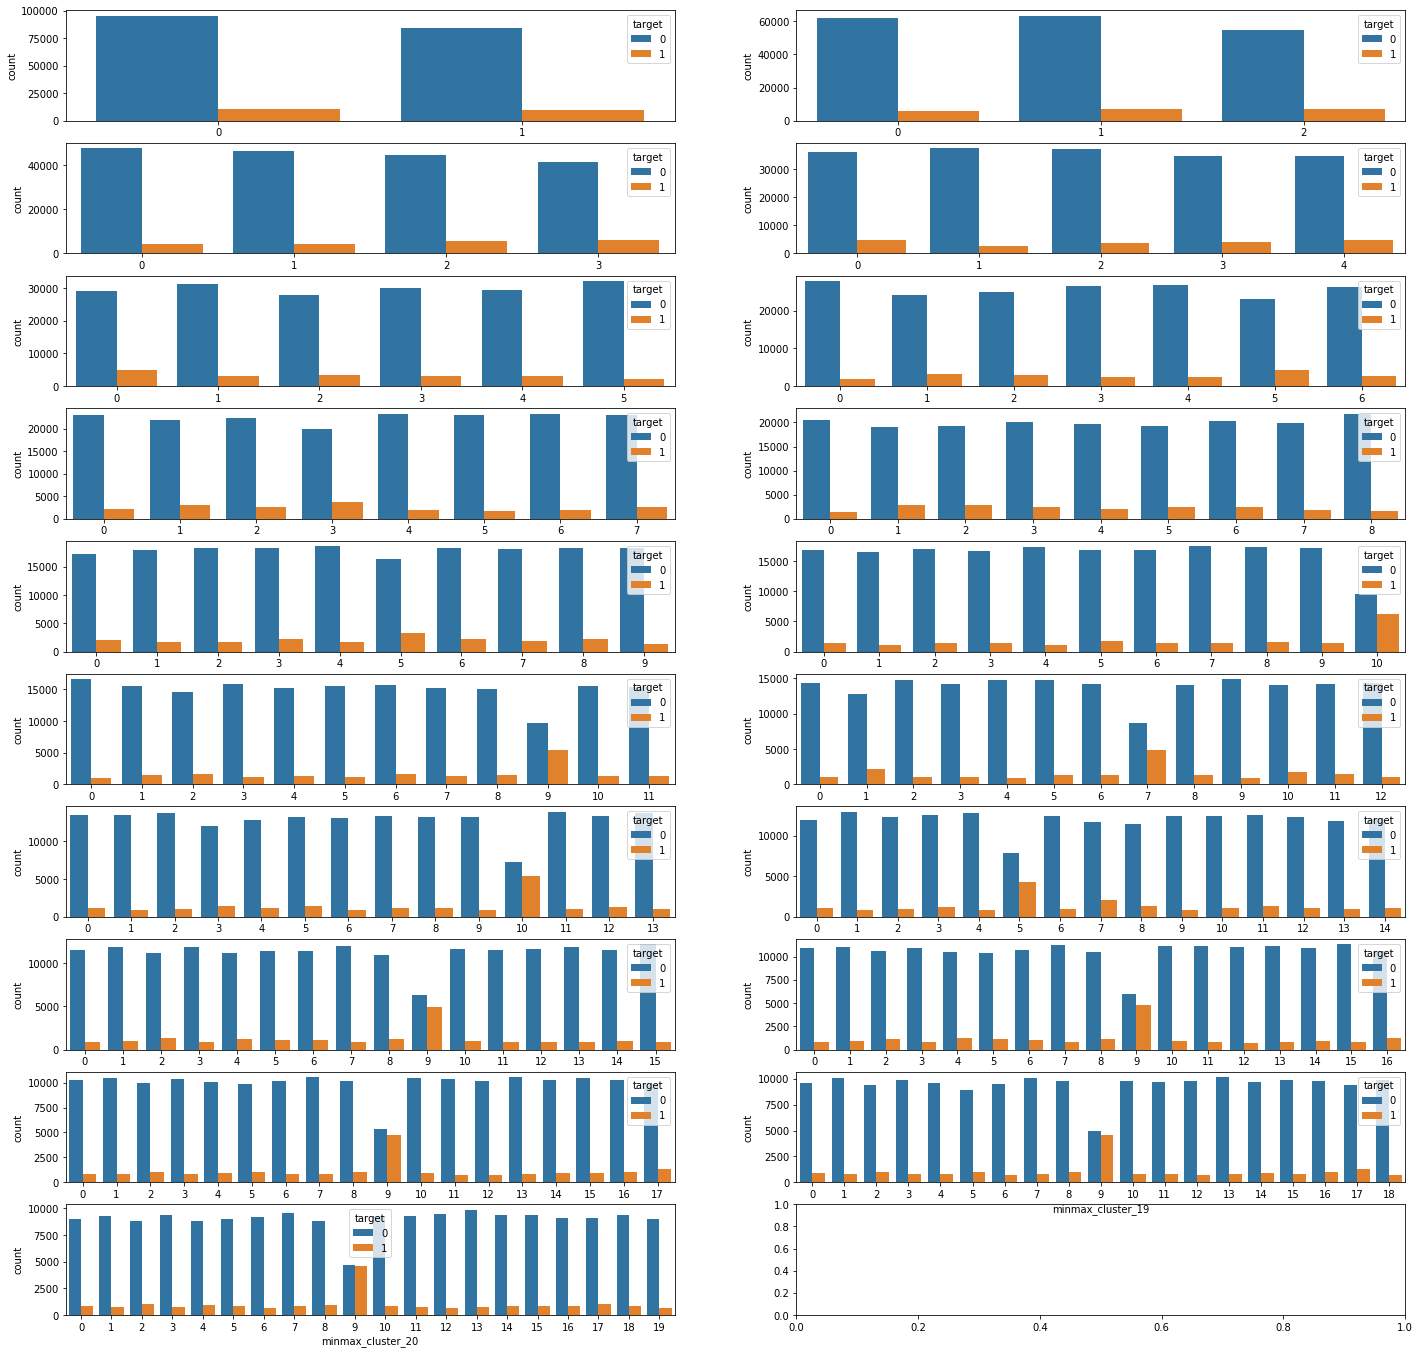

In [146]:
plt.figure()
fig, ax = plt.subplots(10, 2, figsize=(24, 24))

for i, j in enumerate(range(2, 21)):
    plt.subplot(10, 2, i+1)    
    sns.countplot(x=f'minmax_cluster_{j}', hue='target', data=minmax_train)
plt.savefig('cluster.png')
plt.show()

### Standard 

In [159]:
for i in tqdm(range(2, 21)):
    km = KMeans(n_clusters=i, n_init=20, random_state=1, n_jobs=-1)
    km.fit(standard_train[var_columns]) 
    standard_train[f'standard_cluster_{i}'] = km.predict(standard_train[var_columns]) 
    standard_test[f'standard_cluster_{i}'] = km.predict(standard_test[var_columns]) 

100%|██████████| 19/19 [2:03:43<00:00, 390.72s/it]


In [167]:
standard_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_by_cluster_2,cluster_by_cluster_3,cluster_by_cluster_4,cluster_by_cluster_5,cluster_by_cluster_6,cluster_by_cluster_7,cluster_by_cluster_8,cluster_by_cluster_9,standard_cluster_2,standard_cluster_3,standard_cluster_4,standard_cluster_5,standard_cluster_6,standard_cluster_7,standard_cluster_8,standard_cluster_9,standard_cluster_10,standard_cluster_11,standard_cluster_12,standard_cluster_13,standard_cluster_14,standard_cluster_15,standard_cluster_16,standard_cluster_17,standard_cluster_18,standard_cluster_19,standard_cluster_20,cluster_by_standard_cluster_2,cluster_by_standard_cluster_3,cluster_by_standard_cluster_4,cluster_by_standard_cluster_5,cluster_by_standard_cluster_6,cluster_by_standard_cluster_7,cluster_by_standard_cluster_8,cluster_by_standard_cluster_9
0,train_0,0,-0.573930,-1.275655,0.453774,-0.829761,0.236655,-0.537163,-0.338885,0.610620,-1.560352,-1.476589,0.461851,1.079340,-0.050612,-1.717922,0.561270,-0.010482,-1.402806,-0.228650,-1.397715,2.285141,-0.469311,-0.125044,-0.605456,-1.039062,1.008747,-0.822199,-0.190318,0.476579,-0.766378,0.362012,0.926064,1.160792,-1.297294,0.490905,-0.448076,1.298949,-0.488361,0.894228,-1.400108,0.787117,0.180007,-0.321593,0.509995,1.533872,0.455614,0.264714,-1.884311,-0.165755,0.117113,-1.444060,0.254791,1.909094,0.367414,-1.096510,-0.223684,0.365380,-1.509251,-1.117969,-0.271058,1.390123,0.954203,1.454307,0.591192,-0.283600,1.554790,2.257775,0.013581,1.427778,-1.108843,-0.345670,-0.235061,-0.389160,1.152969,-1.439352,1.676442,0.249822,-1.056957,1.136911,0.586748,-1.686222,1.055115,-0.386224,0.569779,0.231890,-0.312115,0.790833,0.476092,0.901351,-0.289468,-1.526681,-0.380413,-1.355286,-0.392392,-1.041857,1.390715,0.432470,-0.638090,-0.182827,0.590989,-1.429637,1.754963,-0.018422,0.489364,-0.692653,1.619142,2.102086,0.487773,-0.086147,-0.667802,1.354011,-0.907091,0.413427,0.376442,-1.931575,-0.568438,-0.265947,0.093403,-0.037348,-0.923826,1.011531,-0.703289,-0.925995,-0.058691,-1.021263,-0.019892,-1.524788,0.839997,-0.503546,-0.245075,-0.000353,0.686669,-0.410372,1.271114,-0.657086,1.619336,0.973980,0.622561,1.549364,0.351204,1.027545,1.002300,-1.262102,1.245332,-0.363583,0.057036,0.902606,0.482446,-1.777204,0.190274,1.217595,0.689557,0.159113,0.456622,-0.013947,0.706811,0.643686,-1.084599,-1.490510,

<Figure size 432x288 with 0 Axes>

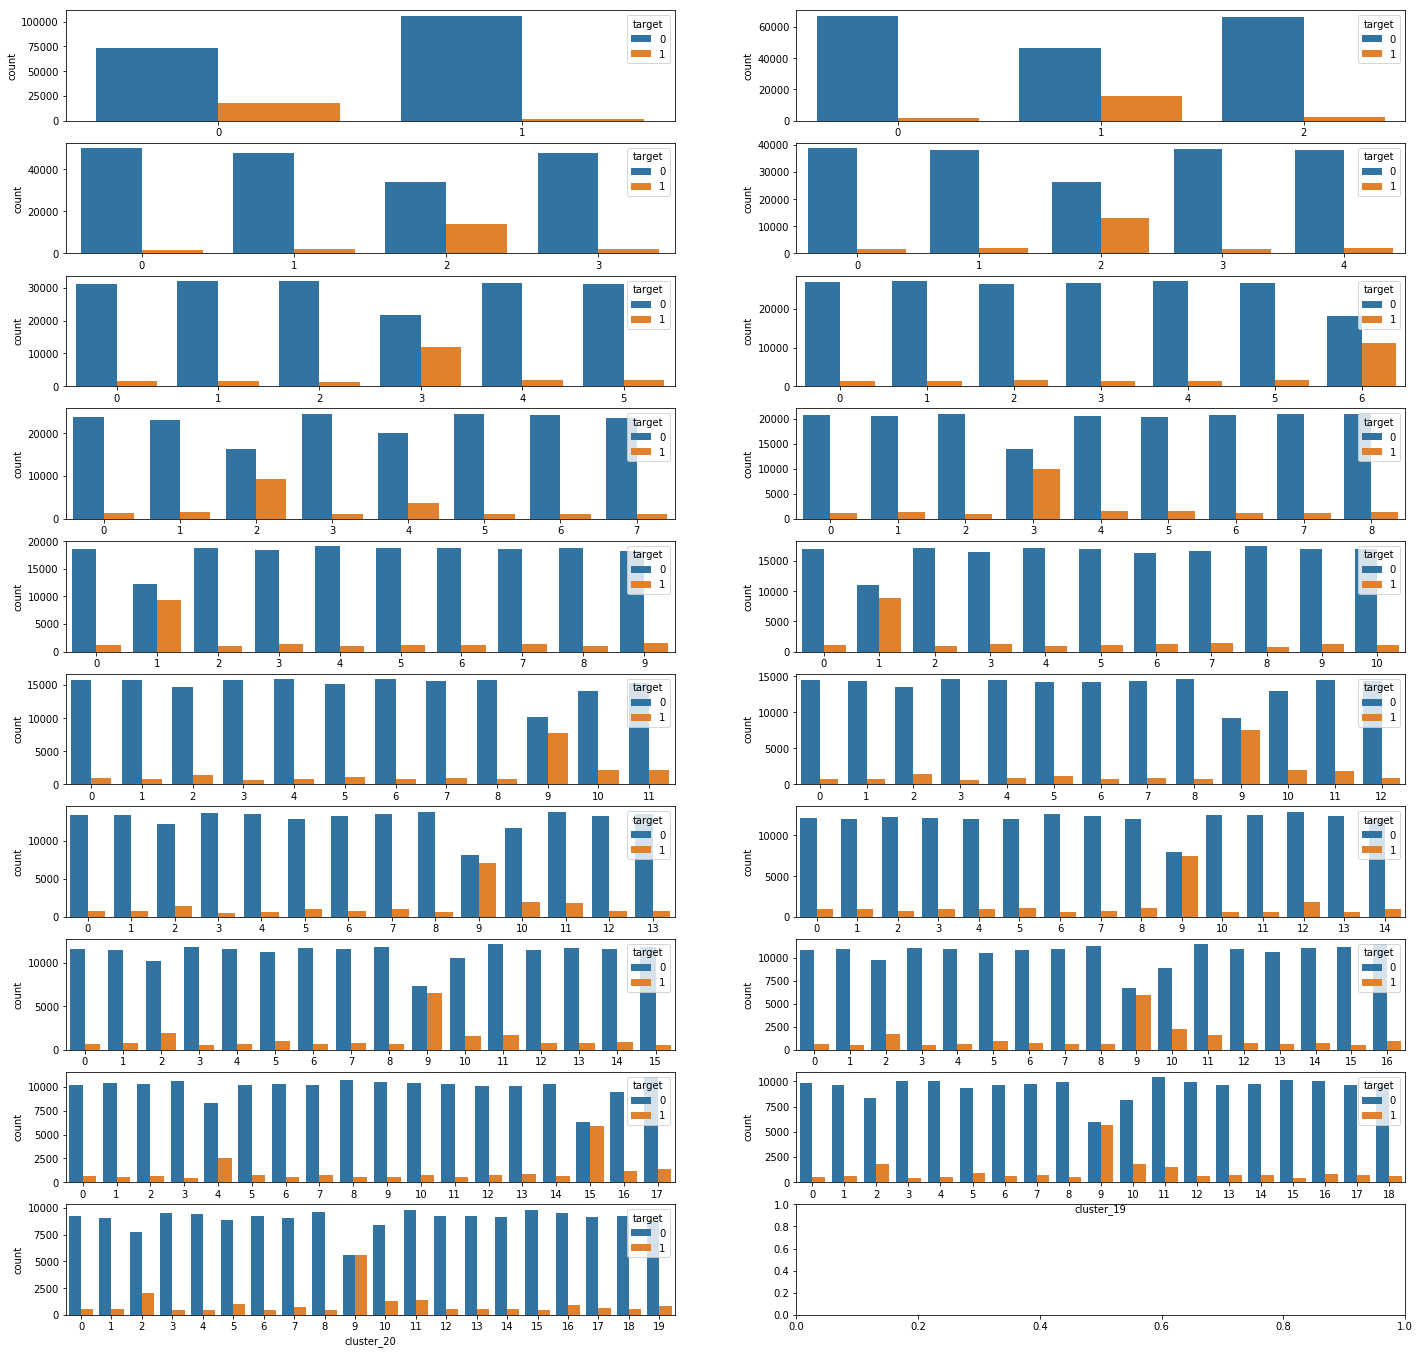

In [112]:
plt.figure()
fig, ax = plt.subplots(10, 2, figsize=(24, 24))

for i, j in enumerate(range(2, 21)):
    plt.subplot(10, 2, i+1)    
    sns.countplot(x=f'standard_cluster_{j}', hue='target', data=standard_train)
plt.savefig('cluster.png')
plt.show()

In [131]:
standard_km_columns = [f'standard_cluster_{i}' for i in range(2, 21)]
for i in tqdm(range(2, 10)):
    km = KMeans(n_clusters=i, n_init=20, random_state=1, n_jobs=-1)
    km.fit(standard_train[standard_km_columns]) 
    standard_train[f'cluster_by_standard_cluster_{i}'] = km.predict(standard_train[standard_km_columns])
    standard_test[f'cluster_by_standard_cluster_{i}'] = km.predict(standard_test[standard_km_columns]) 

100%|██████████| 8/8 [01:10<00:00,  8.87s/it]


<Figure size 432x288 with 0 Axes>

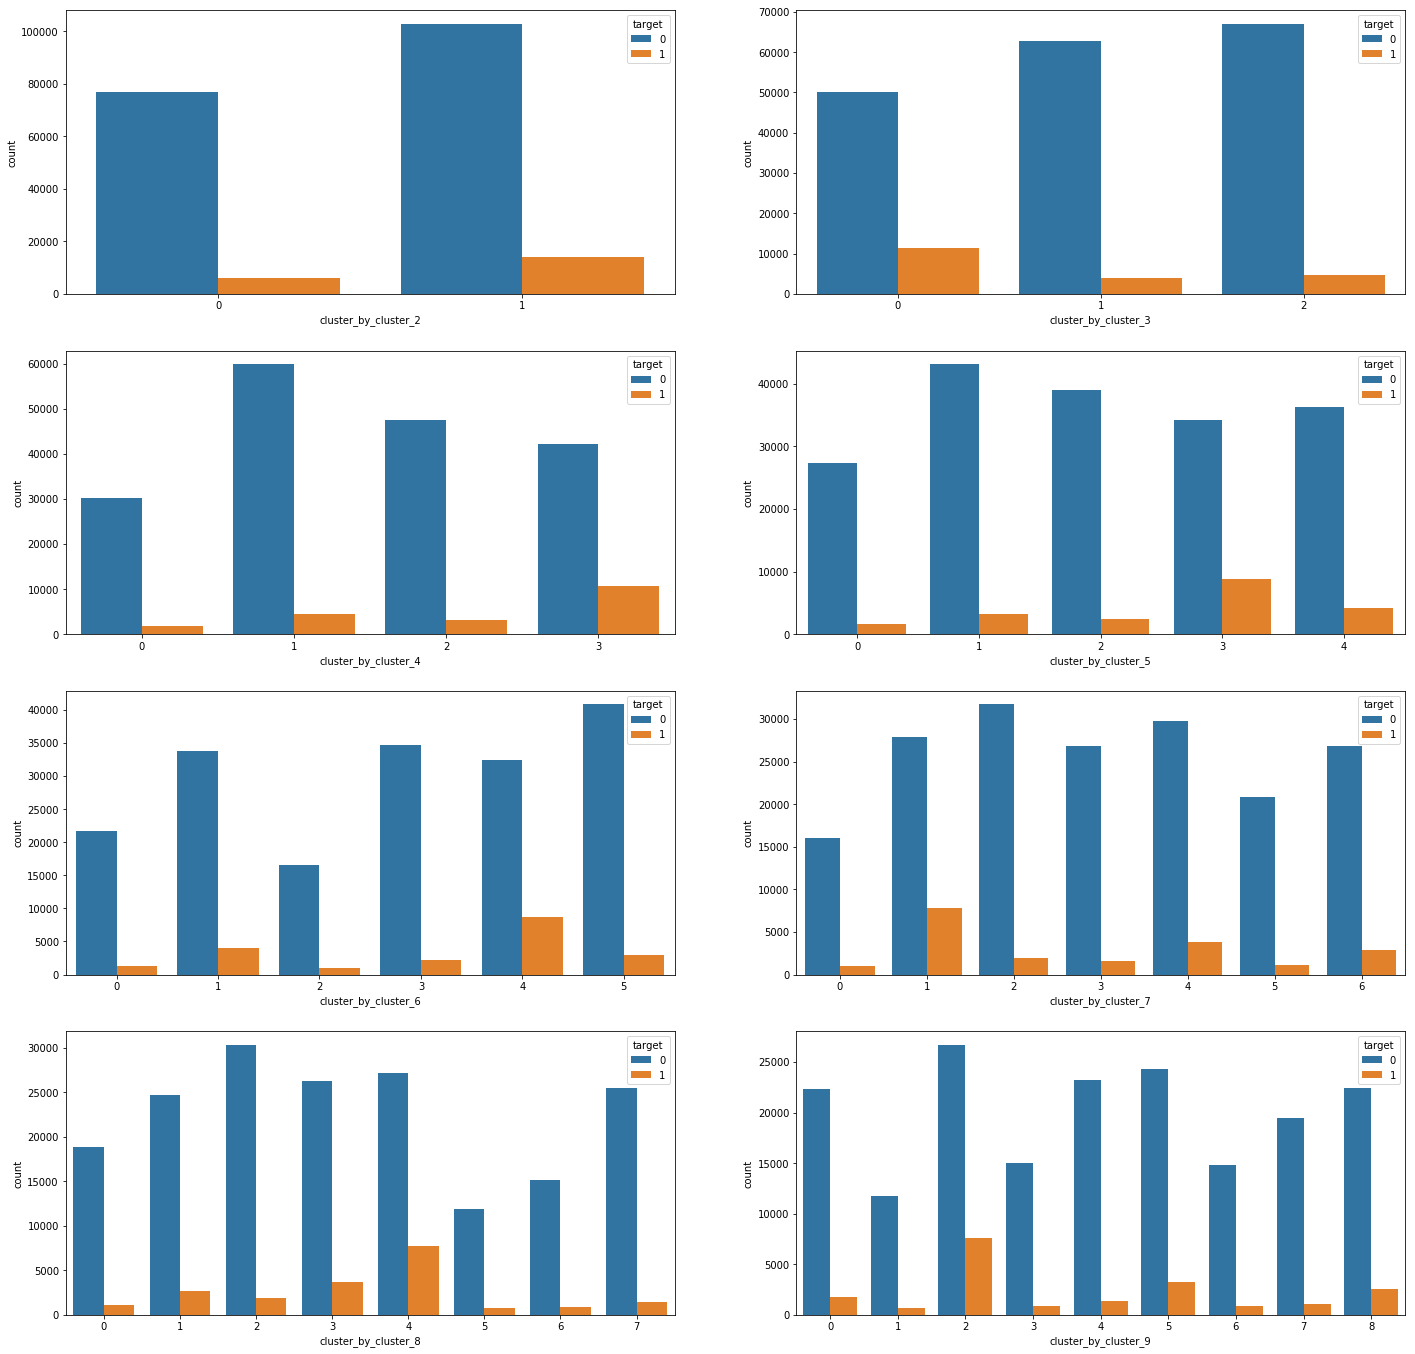

In [132]:
plt.figure()
fig, ax = plt.subplots(4, 2, figsize=(24, 24))

for i, j in enumerate(range(2, 10)):
    plt.subplot(4, 2, i+1)    
    sns.countplot(x=f'cluster_by_cluster_{j}', hue='target', data=standard_train)
plt.savefig('cluster.png')
plt.show()

### manual

In [ ]:
train = df[df['target'].notnull()]
test = df[df['target'].isnull()]

In [ ]:
train['mean_l1_distance_from_0'] = 0
train['mean_l1_distance_from_1'] = 0
test['mean_l1_distance_from_0'] = 0
test['mean_l1_distance_from_1'] = 0

train['mean_l2_distance_from_0'] = 0
train['mean_l2_distance_from_1'] = 0
test['mean_l2_distance_from_0'] = 0
test['mean_l2_distance_from_1'] = 0

train['mean_cosin_similarity_from_0'] = 0
train['mean_cosin_similarity_from_1'] = 0
test['mean_cosin_similarity_from_0'] = 0
test['mean_cosin_similarity_from_1'] = 0

In [ ]:
train['std_l1_distance_from_0'] = 0
train['std_l1_distance_from_1'] = 0
test['std_l1_distance_from_0'] = 0
test['std_l1_distance_from_1'] = 0

train['std_l2_distance_from_0'] = 0
train['std_l2_distance_from_1'] = 0
test['std_l2_distance_from_0'] = 0
test['std_l2_distance_from_1'] = 0

train['std_cosin_similarity_from_0'] = 0
train['std_cosin_similarity_from_1'] = 0
test['std_cosin_similarity_from_0'] = 0
test['std_cosin_similarity_from_1'] = 0

In [ ]:
for fold, (train_index, valid_index) in enumerate(skf.split(train, train['target'])):
    train_ = train.iloc[train_index]
    valid = train.iloc[valid_index]
    
    train_0 = train_.query('target == 0')
    train_1 = train_.query('target == 1')
    
    columns = [f'var_{i}' for i in range(0, 200)]
    
    train_0_mean = train_0[columns].mean(axis=0)
    train_1_mean = train_1[columns].mean(axis=0)
    
    valid['mean_l1_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=1), axis=1)
    valid['mean_l1_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=1), axis=1)
    
    valid['mean_l2_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=2), axis=1)
    valid['mean_l2_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=2), axis=1)
    
#     valid['mean_cosin_similarity_from_0'] = valid[columns].apply(lambda x: distance.cosine(x, train_0_mean), axis=1)
#     valid['mean_cosin_similarity_from_1'] = valid[columns].apply(lambda x: distance.cosine(x, train_1_mean), axis=1)
    
    train.ix[valid.index, 'mean_l1_distance_from_0'] = valid['mean_l1_distance_from_0']
    train.ix[valid.index, 'mean_l1_distance_from_1'] = valid['mean_l1_distance_from_1']
    
    train.ix[valid.index, 'mean_l2_distance_from_0'] = valid['mean_l2_distance_from_0']
    train.ix[valid.index, 'mean_l2_distance_from_1'] = valid['mean_l2_distance_from_1']
    
#     train.ix[valid.index, 'mean_cosine_similarity_from_0'] = valid['mean_cosin_similarity_from_0']
#     train.ix[valid.index, 'mean_cosine_similarity_from_1'] = valid['mean_cosin_similarity_from_1']
        
train_0 = train.query('target == 0')
train_1 = train.query('target == 1')

train_0_mean = train_0[columns].mean(axis=0)
train_1_mean = train_1[columns].mean(axis=0)

test['mean_l1_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=1), axis=1)
test['mean_l1_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=1), axis=1) 

test['mean_l2_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=2), axis=1)
test['mean_l2_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=2), axis=1)    

# test['mean_cosin_similarity_from_0'] = test[columns].apply(lambda x: distance.cosine(x, train_0_mean), axis=1)
# test['mean_cosin_similarity_from_1'] = test[columns].apply(lambda x: distance.cosine(x, train_1_mean), axis=1)    

In [ ]:
for fold, (train_index, valid_index) in enumerate(skf.split(train, train['target'])):
    train_ = train.iloc[train_index]
    valid = train.iloc[valid_index]
    
    train_0 = train_.query('target == 0')
    train_1 = train_.query('target == 1')
    
    columns = [f'var_{i}' for i in range(0, 200)]
    
    train_0_std = train_0[columns].std(axis=0)
    train_1_std = train_1[columns].std(axis=0)
    
    valid['std_l1_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=1), axis=1)
    valid['std_l1_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=1), axis=1)
    
    valid['std_l2_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=2), axis=1)
    valid['std_l2_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=2), axis=1)
    
#     valid['std_cosin_similarity_from_0'] = valid[columns].apply(lambda x: distance.cosine(x, train_0_std), axis=1)
#     valid['std_cosin_similarity_from_1'] = valid[columns].apply(lambda x: distance.cosine(x, train_1_std), axis=1)
    
    train.ix[valid.index, 'std_l1_distance_from_0'] = valid['std_l1_distance_from_0']
    train.ix[valid.index, 'std_l1_distance_from_1'] = valid['std_l1_distance_from_1']
    
    train.ix[valid.index, 'std_l2_distance_from_0'] = valid['std_l2_distance_from_0']
    train.ix[valid.index, 'std_l2_distance_from_1'] = valid['std_l2_distance_from_1']
    
#     train.ix[valid.index, 'std_cosine_similarity_from_0'] = valid['std_cosin_similarity_from_0']
#     train.ix[valid.index, 'std_cosine_similarity_from_1'] = valid['std_cosin_similarity_from_1']
        
train_0 = train.query('target == 0')
train_1 = train.query('target == 1')

train_0_std = train_0[columns].std(axis=0)
train_1_std = train_1[columns].std(axis=0)

test['std_l1_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=1), axis=1)
test['std_l1_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=1), axis=1) 

test['std_l2_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=2), axis=1)
test['std_l2_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=2), axis=1)    

# test['std_cosin_similarity_from_0'] = test[columns].apply(lambda x: distance.cosine(x, train_0_std), axis=1)
# test['std_cosin_similarity_from_1'] = test[columns].apply(lambda x: distance.cosine(x, train_1_std), axis=1)    

In [ ]:
train.head()

In [ ]:
test.head()

## KNeighbors

In [147]:
for i in tqdm(range(2, 11)):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(train[var_columns], train['target']) 
    train[f'neighbors_{i}'] = neigh.predict(train[var_columns])

# Upsampling

# Feature Selection

In [120]:
standard_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_by_cluster_2,cluster_by_cluster_3,cluster_by_cluster_4,cluster_by_cluster_5,cluster_by_cluster_6,cluster_by_cluster_7,cluster_by_cluster_8,cluster_by_cluster_9
0,train_0,0,-0.573930,-1.275655,0.453774,-0.829761,0.236655,-0.537163,-0.338885,0.610620,-1.560352,-1.476589,0.461851,1.079340,-0.050612,-1.717922,0.561270,-0.010482,-1.402806,-0.228650,-1.397715,2.285141,-0.469311,-0.125044,-0.605456,-1.039062,1.008747,-0.822199,-0.190318,0.476579,-0.766378,0.362012,0.926064,1.160792,-1.297294,0.490905,-0.448076,1.298949,-0.488361,0.894228,-1.400108,0.787117,0.180007,-0.321593,0.509995,1.533872,0.455614,0.264714,-1.884311,-0.165755,0.117113,-1.444060,0.254791,1.909094,0.367414,-1.096510,-0.223684,0.365380,-1.509251,-1.117969,-0.271058,1.390123,0.954203,1.454307,0.591192,-0.283600,1.554790,2.257775,0.013581,1.427778,-1.108843,-0.345670,-0.235061,-0.389160,1.152969,-1.439352,1.676442,0.249822,-1.056957,1.136911,0.586748,-1.686222,1.055115,-0.386224,0.569779,0.231890,-0.312115,0.790833,0.476092,0.901351,-0.289468,-1.526681,-0.380413,-1.355286,-0.392392,-1.041857,1.390715,0.432470,-0.638090,-0.182827,0.590989,-1.429637,1.754963,-0.018422,0.489364,-0.692653,1.619142,2.102086,0.487773,-0.086147,-0.667802,1.354011,-0.907091,0.413427,0.376442,-1.931575,-0.568438,-0.265947,0.093403,-0.037348,-0.923826,1.011531,-0.703289,-0.925995,-0.058691,-1.021263,-0.019892,-1.524788,0.839997,-0.503546,-0.245075,-0.000353,0.686669,-0.410372,1.271114,-0.657086,1.619336,0.973980,0.622561,1.549364,0.351204,1.027545,1.002300,-1.262102,1.245332,-0.363583,0.057036,0.902606,0.482446,-1.777204,0.190274,1.217595,0.689557,0.159113,0.456622,-0.013947,0.706811,0.643686,-1.084599,-1.490510,-0.039898,0.317585,-0.803904,-1.472873,-1.227149,-1.134916,1.748054,-1.322378,-0.709604,0.444485,1.506467,-0.399789,-1.074721,-1.414388,0.124363,0.639983,-0.234707,-1.348754,-0.973611,0.704167,-0.295881,-0.309423,-1.081917,-0.778267,0.265592,1.252905,1.406139,2.084604,0.896304,-0.812759,0.559490,-0.169192,0.268524,-1.152071,0.817682,-0.409608,0.168050,-1.580891,1.024023,-0.376431,-1.026522,0.210689,1,0,0,1,5,1,0,1,7,9,0,0,0,1,0,16,13,12,0,0,2,1,1,5,6,5,1
1,train_1,0,0.273590,-0.623288,1.193406,-0.685231,0.793204,1.538372,0.241141,-0.001080,0.859932,0.418964,-0.142793,1.896726,0.003053,-0.026338,-0.932968,

## MinMax

In [148]:
y = train['target']

not_use_cols = ['ID_code', 'target'] 
use_cols = [c for c in train.columns if c not in not_use_cols]
use_cols = [f'minmax_cluster_{i}' for i in range(2, 21)]

In [149]:
X = minmax_train[use_cols]
X_test = minmax_test[use_cols]

## Standard

In [168]:
y = train['target']

not_use_cols = ['ID_code', 'target'] 
use_cols = [c for c in standard_train.columns if c not in not_use_cols]
# use_cols = [f'standard_cluster_{i}' for i in range(2, 21)]

In [169]:
X = standard_train[use_cols]
X_test = standard_test[use_cols]

KeyError: "['cluster_2' 'cluster_3' 'cluster_4' 'cluster_5' 'cluster_6' 'cluster_7'\n 'cluster_8' 'cluster_9' 'cluster_10' 'cluster_11' 'cluster_12'\n 'cluster_13' 'cluster_14' 'cluster_15' 'cluster_16' 'cluster_17'\n 'cluster_18' 'cluster_19' 'cluster_20' 'cluster_by_cluster_2'\n 'cluster_by_cluster_3' 'cluster_by_cluster_4' 'cluster_by_cluster_5'\n 'cluster_by_cluster_6' 'cluster_by_cluster_7' 'cluster_by_cluster_8'\n 'cluster_by_cluster_9'] not in index"

In [151]:
# kmeans_train = pd.concat([minmax_train, standard_train], axis=1)
# kmeans_test = pd.concat([minmax_test, standard_test], axis=1)

In [152]:
# y = train['target']

# not_use_cols = ['ID_code', 'target'] 
# # use_cols = [c for c in train.columns if c not in not_use_cols]
# # use_cols = var_columns
# use_cols += [f'standard_cluster_{i}' for i in range(2, 21)]
# use_cols += [f'minmax_cluster_{i}' for i in range(2, 21)]

In [162]:
# X = kmeans_train[use_cols]
# X_test = kmeans_test[use_cols]

In [166]:
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,-0.573930,-1.275655,0.453774,-0.829761,0.236655,-0.537163,-0.338885,0.610620,-1.560352,-1.476589,0.461851,1.079340,-0.050612,-1.717922,0.561270,-0.010482,-1.402806,-0.228650,-1.397715,2.285141,-0.469311,-0.125044,-0.605456,-1.039062,1.008747,-0.822199,-0.190318,0.476579,-0.766378,0.362012,0.926064,1.160792,-1.297294,0.490905,-0.448076,1.298949,-0.488361,0.894228,-1.400108,0.787117,0.180007,-0.321593,0.509995,1.533872,0.455614,0.264714,-1.884311,-0.165755,0.117113,-1.444060,0.254791,1.909094,0.367414,-1.096510,-0.223684,0.365380,-1.509251,-1.117969,-0.271058,1.390123,0.954203,1.454307,0.591192,-0.283600,1.554790,2.257775,0.013581,1.427778,-1.108843,-0.345670,-0.235061,-0.389160,1.152969,-1.439352,1.676442,0.249822,-1.056957,1.136911,0.586748,-1.686222,1.055115,-0.386224,0.569779,0.231890,-0.312115,0.790833,0.476092,0.901351,-0.289468,-1.526681,-0.380413,-1.355286,-0.392392,-1.041857,1.390715,0.432470,-0.638090,-0.182827,0.590989,-1.429637,1.754963,-0.018422,0.489364,-0.692653,1.619142,2.102086,0.487773,-0.086147,-0.667802,1.354011,-0.907091,0.413427,0.376442,-1.931575,-0.568438,-0.265947,0.093403,-0.037348,-0.923826,1.011531,-0.703289,-0.925995,-0.058691,-1.021263,-0.019892,-1.524788,0.839997,-0.503546,-0.245075,-0.000353,0.686669,-0.410372,1.271114,-0.657086,1.619336,0.973980,0.622561,1.549364,0.351204,1.027545,1.002300,-1.262102,1.245332,-0.363583,0.057036,0.902606,0.482446,-1.777204,0.190274,1.217595,0.689557,0.159113,0.456622,-0.013947,0.706811,0.643686,-1.084599,-1.490510,-0.039898,0.317585,-0.803904,-1.472873,-1.227149,-1.134916,1.748054,-1.322378,-0.709604,0.444485,1.506467,-0.399789,-1.074721,-1.414388,0.124363,0.639983,-0.234707,-1.348754,-0.973611,0.704167,-0.295881,-0.309423,-1.081917,-0.778267,0.265592,1.252905,1.406139,2.084604,0.896304,-0.812759,0.559490,-0.169192,0.268524,-1.152071,0.817682,-0.409608,0.168050,-1.580891,1.024023,-0.376431,-1.026522,0.210689
1,0.273590,-0.623288,1.193406,-0.685231,0.793204,1.538372,0.241141,-0.001080,0.859932,0.418964,-0.142793,1.896726,0.003053,-0.026338,-0.932968,-2.121009,1.763925,-1.468794,-0.949769,2.017102,-1.677817,-1.769110,1.493395,0.667354,-0.953338,0.783788,-1.305830,-0.934811,-0.618767,-1.723095,-0.202172,-1.169302,0.697285,1.064423,-0.118884,-0.602195,0.192043,-0.012680,0.040056,0.739003,-0.528882,-1.247599,-1.933456,0.693229,-1.304535,-1.621062,-1.377728,1.199009,1.731144,1.146495,-1.315420,-0.022553,-0.318504,0.884857,-1.096658,1.026892,0.763114,0.927791,-0.293685,-0.071892,-0.983580,0.405037,0.451776,-

# CV

In [153]:
oof, predictions, scores, feature_importance_df = cv_lightgbm(X, y, X_test) 

cv_score = roc_auc_score(y, oof)**0.5
print('Num folds: {}'.format(NFOLDS))
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

fold: 1/5
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.739923	valid_1's auc: 0.73212
Early stopping, best iteration is:
[640]	training's auc: 0.74416	valid_1's auc: 0.733895
fold: 2/5
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [ ]:
feature_importance_df['importance'] = feature_importance_df['importance'].astype('int')
ordered_feature = feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 48))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)
plt.show()

In [ ]:
submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))
submission['target'] = predictions
submission.to_csv(os.path.join('..', 'submission', '{}_lightgbm.csv'.format(str(datetime.datetime.today().date()).replace('-', ''))), index=False)

In [144]:
def cv_lightgbm(X, y, X_test, NFOLDS=5, SEED=2020):
    params_in_train = {
        'num_boost_round': 20000,
        'early_stopping_rounds': 200,
        'verbose_eval': 500,
    }

    skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    oof = np.zeros(len(X))
    predictions = np.zeros(len(X_test))
    scores = {'train': [], 'valid': []}
    features = X.columns
    feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print('fold: {}/{}'.format(fold+1, skf.n_splits))
        
        params = {
            'boosting': 'gbdt',
            'metric': 'auc',
            'objective': 'binary',
            'max_depth': 6,
            'num_leaves': 12,
            'min_data_in_leaf': 64,
            'bagging_freq': 5,
            'learning_rate': 0.01,
            'bagging_fraction': 0.4,
            'num_threads': cpu_count(),
            'verbose': -1,
            'seed': int(2**fold),
            'bagging_seed': int(2**fold),
            'drop_seed': int(2**fold),
        }
        
        dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
        dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
        
        model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
        scores['train'].append(model.best_score['training']['auc'])
        scores['valid'].append(model.best_score['valid_1']['auc'])
        oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

        fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
        fold_feature_importance_df['feature'] = features
        fold_feature_importance_df['importance'] = model.feature_importance()
        fold_feature_importance_df['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

        predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

        del model

    return oof, predictions, scores, feature_importance_df